# Visualizing data augmentations

In [1]:
%matplotlib inline

In [2]:
import torch 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid #imagegrids for visualizing the top 10 matches
from PIL import Image
from load_vissl_model import load_model #self defined function to reconstruct a vissl model
from pathlib import Path

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



Loading vissl model

In [3]:
#Specify the model below! Possible options are:
#"rotnet", "jigsaw", "moco", "simclr" and "swav"
model_name = "jigsaw"
model = load_model(model_name, verbose=True)

#checking for the best device to run model on
device = torch.device("cpu") 
# if(torch.cuda.is_available()):
#     device = torch.device("cuda")
#     model.to(device) #move model to gpu
print(f"using {device} device", end="\n\n")

In function load_model()
Train config at (relative path from vissl/...):
validation/jigsaw_full/train_config.yaml
SSL pretrained weights at:
/home/olivier/Documents/master/mp/checkpoints/sku110k/jigsaw_full/model_final_checkpoint_phase104.torch


/home/olivier/Documents/master/mp/.venv/lib/python3.8/site-packages/hydra/plugins/config_source.py:190: UserWarning: 
Missing @package directive config/validation/jigsaw_full/train_config.yaml in pkg://configs.
See https://hydra.cc/docs/next/upgrades/0.11_to_1.0/adding_a_package_directive
  warnings.warn(message=msg, category=UserWarning)


Model jigsaw was succusfully build
Weights for model jigsaw succesfully loaded
using cpu device



Loading images

In [4]:
#path where images are stored 
CornerShop = Path("/home/olivier/Documents/master/mp/CornerShop/CornerShop/crops")
img_paths = CornerShop.glob("*/*.jpg")

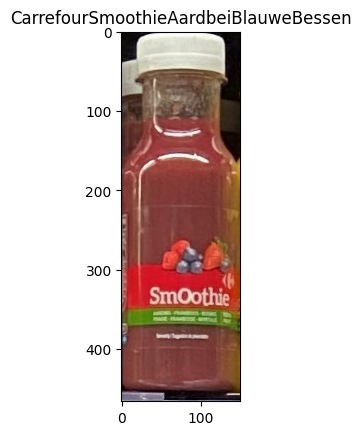

In [11]:
img_path = next(img_paths) #cycing trough the cornershop image dataset
label = img_path.parent.stem #extracting foldername as label for image
image = Image.open(img_path)
plt.title(label)
plt.imshow(image)

## Visualizing tranforms

In [12]:
#visualization for the matching results:
def show_img_grid(imgs):
    """ Makes an imagegrid of 10 images in a 2x5 config:
        Args:
            imgs : tuple of 10 imgs
    """
    #creating matlab figure
    fig = plt.figure(figsize=(10., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                     axes_pad=0.4,  # pad between axes in inch.
                     )
    i=1
    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.set_title(f"Aug. #{i}")
        ax.imshow(im)
        i+=1

    plt.show()

### The effect of ten_crop

<class 'PIL.Image.Image'>


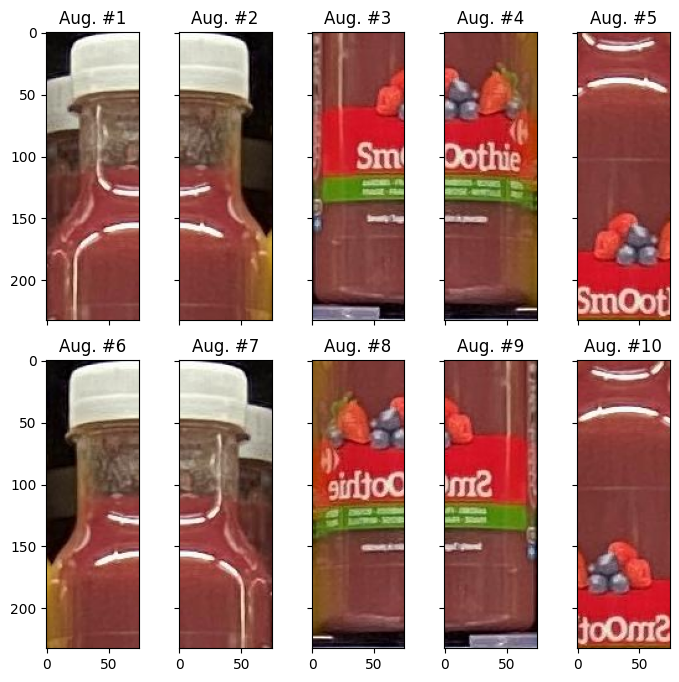

In [13]:
# Convert images to RGB. This is important
# as the model was trained on RGB images.
image = image.convert("RGB")

# Image transformation pipeline.
pipeline = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(256),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#test time augmenting
#take 10 crops
width, height = image.size #Image size, in pixels. The size is given as a 2-tuple (width, height).
ten_crops=transforms.functional.ten_crop(image, size=(height/2, width/2)) 
print(type(ten_crops[0]))
show_img_grid(ten_crops)

### The effect of the transformation pipeline
Applying the pipeline to all 10 crops.

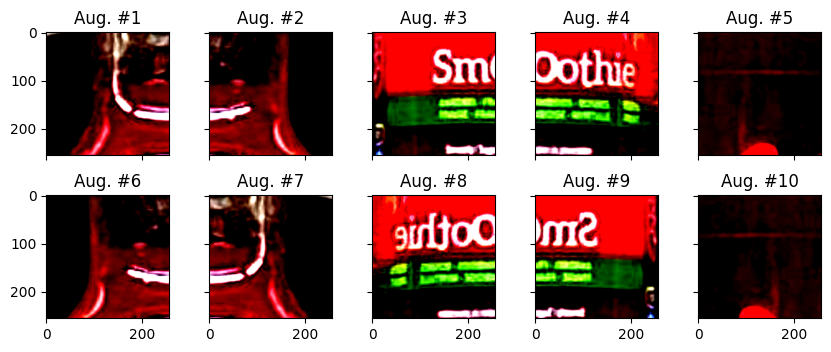

In [14]:
#push them through the transform pipeline
transformed_crops = [pipeline(crop) for crop in ten_crops]
#print(type(transformed_crops[0]))

#converting input tensor back to 2d image with color channels
augmentations = [inp.numpy().transpose((1, 2, 0)) for inp in transformed_crops]
augmentations_clipped = [np.clip(inp, 0, 1) for inp in augmentations] #clip values between 0,1
show_img_grid(augmentations_clipped)

### The transformation pipeline (unnormalized)

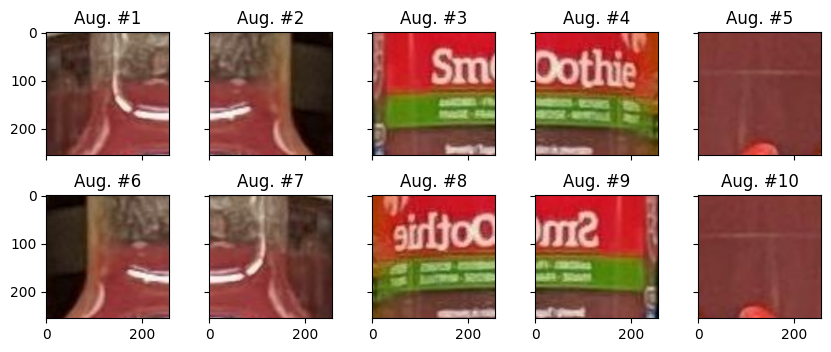

In [15]:
#normalization parameters
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
#unnormalize
augmentations_unnormalized = [(std * inp + mean) for inp in augmentations]
augmentations_unnormalized = [np.clip(inp, 0, 1) for inp in augmentations_unnormalized]
show_img_grid(augmentations_unnormalized)